In [1]:
import os
for dirname, _, filenames in os.walk('../input/dogs-vs-cats'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/dogs-vs-cats/test1.zip
../input/dogs-vs-cats/train.zip
../input/dogs-vs-cats/sampleSubmission.csv


In [2]:
#libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator 
from zipfile import ZipFile

# Data Processing

In [3]:
ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r").extractall()
ZipFile("/kaggle/input/dogs-vs-cats/test1.zip", "r").extractall()

In [4]:
train_path = "./train"
test_path = "./test1"

In [5]:
file_names = os.listdir(train_path)
categories = []
for path in file_names:
    animal_type = path.split('.')[0]
    categories.append(animal_type)

In [6]:
df = pd.DataFrame({'Image': file_names, 'Animal': categories})
df.sample(5)

,Image,Animal
1176,dog.1149.jpg,dog
7429,cat.2061.jpg,cat
17155,cat.2384.jpg,cat
12117,dog.5456.jpg,dog
19115,cat.6850.jpg,cat


In [7]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

print(df_train.shape)
print(df_valid.shape)

(20000, 2)
(5000, 2)


In [8]:
# augment training data

datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=30,
                              width_shift_range=0.1, height_shift_range=0.1,
                              shear_range=0.2, zoom_range=0.2,
                              horizontal_flip=True, fill_mode='nearest')

#augment validating data

datagen_valid = ImageDataGenerator(rescale=1./255)

In [9]:
aug_train = datagen_train.flow_from_dataframe(df_train, directory=train_path, 
                                             x_col='Image', y_col='Animal',
                                             target_size=(224, 224), class_mode='binary',
                                             batch_size=64)

aug_valid = datagen_valid.flow_from_dataframe(df_valid, directory=train_path,
                                             x_col='Image', y_col='Animal',
                                             target_size=(224, 224), class_mode='binary',
                                             batch_size=64)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# Training the Model

In [10]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1,
                           save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=9, verbose=1)
rdlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [checkpoint, rdlr, es]

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))  

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [13]:
hist=model.fit(aug_train, validation_data=aug_valid, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50
313/313 [==============================] - 299s 930ms/step - loss: 0.6585 - accuracy: 0.5887 - val_loss: 0.6824 - val_accuracy: 0.5584

Epoch 00001: val_accuracy improved from -inf to 0.55840, saving model to best_model.h5
Epoch 2/50
313/313 [==============================] - 290s 927ms/step - loss: 0.6092 - accuracy: 0.6507 - val_loss: 0.5667 - val_accuracy: 0.7108

Epoch 00002: val_accuracy improved from 0.55840 to 0.71080, saving model to best_model.h5
Epoch 3/50
313/313 [==============================] - 288s 921ms/step - loss: 0.5869 - accuracy: 0.6808 - val_loss: 0.5660 - val_accuracy: 0.7106

Epoch 00003: val_accuracy did not improve from 0.71080
Epoch 4/50
313/313 [==============================] - 289s 922ms/step - loss: 0.5673 - accuracy: 0.6901 - val_loss: 0.5096 - val_accuracy: 0.7656

Epoch 00004: val_accuracy improved from 0.71080 to 0.76560, saving model to best_model.h5
Epoch 5/50
313/313 [==============================] - 288s 921ms/step - loss: 0.5539 - acc

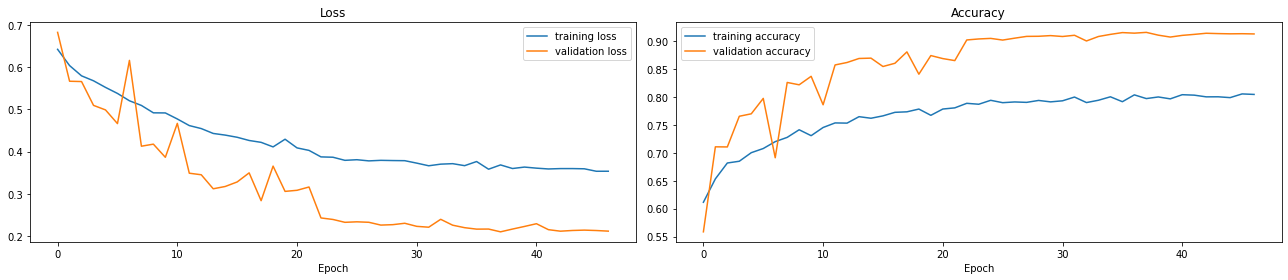

In [14]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
plt.title('Loss')
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('Learning rate.png')
plt.show()

In [15]:
best_model = load_model('best_model.h5')

In [16]:
file_names = os.listdir(test_path)
df_test = pd.DataFrame({'Image':file_names})

df_test.sample(5)

,Image
2750,580.jpg
2777,1683.jpg
11235,2751.jpg
5537,10610.jpg
7791,2788.jpg


In [17]:
aug_test = datagen_valid.flow_from_dataframe(df_test, directory=test_path, x_col='Image',
                                             y_col=None, class_mode=None, target_size= (224, 224),
                                             batch_size=64, shuffle=False)

Found 12500 validated image filenames.


In [18]:
pred = best_model.predict(aug_test)

In [19]:
pred = np.where(pred > 0.5, 'Dog', 'Cat')

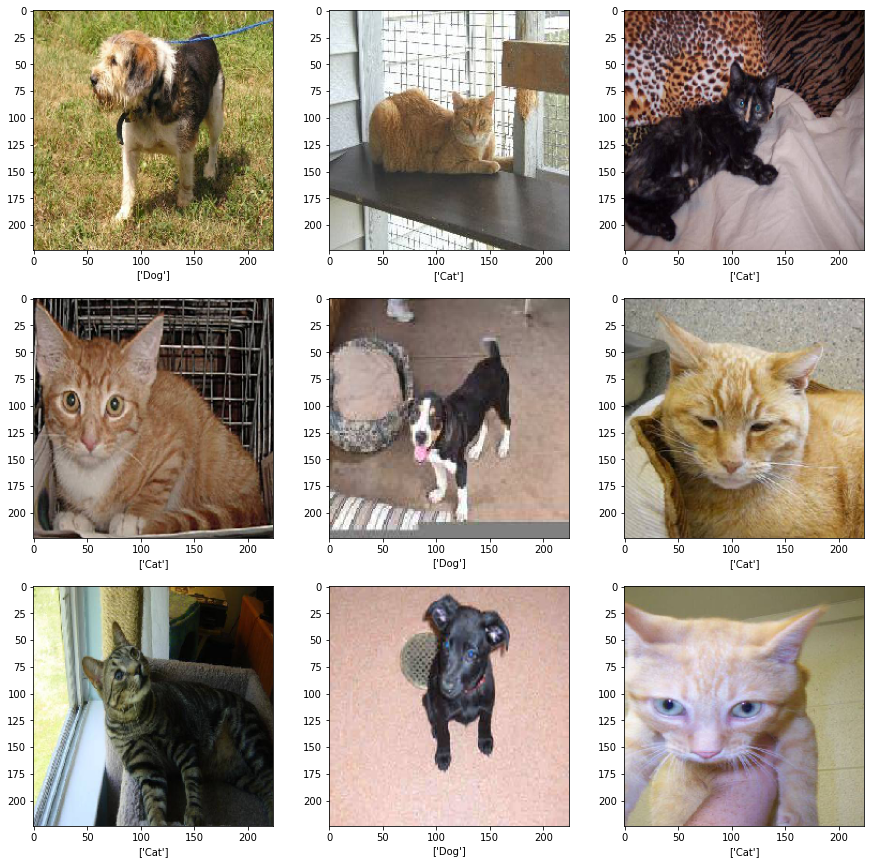

In [20]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(aug_test[0][i])
    plt.xlabel(pred[i])
    
plt.show()

In [21]:
label = np.where(pred == 'Cat', 0, 1)

In [22]:
df_submission = pd.read_csv('../input/dogs-vs-cats/sampleSubmission.csv')
df_submission['label'] = label
df_submission.to_csv('submission.csv', index=False)